<h1>Fermi-Hubbard Hamiltonian (1d & 2d)</h1>

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

<hr><hr>

This notebook provides a short introduction to circuit generation and resource analysis for Fermi-Hubbard model in one and two spatial dimensions. Although emphasis is placed on circuits for quantum dynamics, components for state preparation and analysis methods are also critical in a realistic workflow.  Procedures that handle these tasks will be added later.

<b>WARNING:</b> <i>This notebook is an ALPHA release.  Although these methods represent (in part) the future of  pyLIQTR,  some components are unique to the ALPHA notebooks and they may be subject to change in a final release.  Be diligent when integrating these methods into existing workflows.</i>

<h2>Introduction</h2>

The complexity of the 2d Fermi-Hubbard (FH) model is hidden by its visual simplicity.  We define this problem through the Hamiltonian,

\begin{equation}
H = \underbrace{-J\sum_{\langle jk; nm\rangle,\sigma} \left[c^\dagger_{jk,\sigma} c_{nm,\sigma} + c^\dagger_{nm,\sigma} c_{jk,\sigma}\right]}_{\text{Hopping}} + \underbrace{U \sum_{\langle jk \rangle} n_{jk,\uparrow} n_{jk,\downarrow}}_{\text{Density Interaction}},
\end{equation}

 where   angle brackets  denote summation over pairs of lattice sites and $\sigma \in \{\uparrow,\downarrow\}$  indexes spin-1/2 eigenstates.  Following this, the operators $c^\dagger_{jk,\sigma}, c_{jk,\sigma}$ describe the creation or annihilation of a spin-$\sigma$ fermion on the  $(j,k)$-th site  and  $n_{k,\sigma} = c^\dagger_{k,\sigma} c_{k,\sigma}$ is the associated number operator.  Our discussion will address a case where each site contains a single orbital (accepting one fermion of each spin state) and where hopping is restricted to nearest-neighbors on a rectangular lattice.  

From a physical standpoint, the first term in this Hamiltonian describes carrier hopping  (with coupling $J$), while the second constitutes an on-site density interaction between different spin channels (with strength $U$). The latter  facilitates the development of strongly-correlated electronic states, leading to an intricate phase diagram that remains poorly understood.  It is nonetheless clear that the ratio $U/J$ and the fraction of filled orbitals are key parameters, delineating the strength of many-body correlations and the competition between electronic and magnetic order.  It is anticipated that the emergent physics of FH could span from established Mott insulating and antiferromagnetic regimes to (non)-Fermi liquid behavior and unconventional superconducting phases.  Unfortunately, FH is analytically intractable within most domains for interest, and accurate computational methods suffer from an exponential blow-up with problem size.


<b>Note:</b> <i> The conventions that we follow in this notebook are not strict requirements.  While our approach parallels most contemporary calculations, this model can be extended to include broader physical regimes (e.g., long-range couplings, multiple orbitals, arbitrary geometries, anisotropies, or higher dimensionality).</i>



<hr>
<h2>From Operators to Qubits</h2>

<h3>Jordan-Wigner Transform</h3>


There is no unique mapping between fermionic Fock-space operators and qubits.  Instead, we have numerous representations that differ in their degree of locality and computational overhead.  This section introduces the Jordan-Wigner transform (JWT), which is arguably the most conceptually straightforward correspondence [<i>Note: Bravyi-Kitaev and other fermionic representations will be added in due course</i>].

The JWT gives a mapping between spinless fermions and su(2) operations (or hard-core bosons).  Stated explicitly, we can write Fock space operators $c^\dagger,c$ for spinless fermions  in terms of spin ladder operators $\sigma_j^{\pm} = (X_j \pm \imath Y_j)/2$ so that,


\begin{align}
c_j &=  (-Z_m)^{\otimes (j-1)} \otimes \sigma^-_j \otimes I^{\otimes(N-j)} \\
c^\dagger_j &= (-Z_m)^{\otimes (j-1)}   \otimes \sigma^+_j \otimes I^{\otimes(N-j)}. \\
\end{align}

 We have a adopted the notation $Z^{\otimes N} = \bigotimes_{m=1}^N Z_m$ for the $N$-fold tensor product and write $I^{\otimes N}$ is the identity operator on $N$ qubits.  After some straightforward algebra, we obtain expressions for components of the hopping terms in tight-binding chains,

\begin{equation}
c^\dagger_j c_k = \sigma^+_j \otimes (-Z)^{\otimes (k-j-1)} \otimes \sigma^-_k,
\end{equation}

and the fermionic number operators,

\begin{equation}
n_k = c^\dagger_k c_k = (I_k + Z_k)/2.
\end{equation}

Note that some authors switch $\sigma^-$ and $\sigma^+$ when defining the JWT, which ultimately flips $Z_K \mapsto -Z_k$ in the number operator. As a general rule, the "one-dimensional" arrangement of our Fock space implies that fermionic operators on non-adjacent sites will map to Pauli strings with an interstitial strech of Pauli $Z$ operations.  These track the signs associated with fermionic exchange statistics.

A note regarding conventions: we will write tensor products explicitly for qubits / qubit operations from this point onward.  We will also add explict labels (subscripts) for the qubits targeted by an operator, unless it is unambiguous from context.  As a final note, the index of a target qubit will always increase when reading a Pauli string from left-to-right.

<h3>Fermi Hubbard in One Dimension</h3>

The 1-$d$ FH Hamiltonian is a simplification of the general case,

\begin{equation}
H = \underbrace{-J\sum_{k,\sigma} \left[c^\dagger_{k+1,\sigma} c_{k,\sigma} + c^\dagger_{k,\sigma} c_{k+1,\sigma}\right]}_{\text{Hopping}} + \underbrace{U \sum_k n_{k,\uparrow} n_{k,\downarrow}}_{\text{Density Interaction}}.
\end{equation}

While the Jordan-Wigner transform gives a mapping between Fermions and qubits, it is only defined for spinless fermions. To accomodate this, we use a standard approach and recast the problem on a bipartite lattice.  



<figure>
<center><img src="./figures/fh_1d_strings.png" width=600></img></center>
</figure>

This is depicted schematically in the diagram above. The one-dimensional lattice  in (<b>a</b>) is our starting point, containing $N$ single-orbital sites that permit fermion occupancy in both spin-up and spin-down states. Hopping occurs between nearest neighbors and the spin channels couple through an on-site density interaction. Our mapping to spinless fermions expands the lattice into a $2N$ site chain and gives a bipartite repartitioning into sublattices for each spin state (<b>b</b>).  Spin-up  or spin-down particles now occupy odd (green) or even lattice sites (orange), respectively.  Since hopping is restricted to a given spin channel (e.g., there is no spin-flip during hopping), we must extend our nearest-neighbor coupling to next-nearest neighbors (orange and green dashed lines).  Conversely, the on-site spin density interaction is now defined between pairs of consecutive sites (designated by the blue circles).  The Jordan-Wigner strings pick up an additional Pauli Z operator when traversing the chain due to an interstitial site from the opposite-spin sublattice. 


The arrangement above can be implemented through the mapping,

\begin{align}
c_{k,\uparrow}   &\mapsto c_{2k - 1} &  \,\,\,\,\,\,\,  & c_{k+1,\uparrow} & \mapsto c_{2k + 1} \\
c_{k,\downarrow} &\mapsto c_{2k}     &  \,\,\,\,\,\,\,  & c_{k+1,\downarrow} & \mapsto c_{2k+2},
\end{align}

which leads to a Hamiltonian for the expanded system,

\begin{equation}
H = -J\sum_{k=1}^{N/2}  \Big[ \underbrace{c_{2k+1}^\dagger c_{2k-1} + c^\dagger_{2k-1} c_{2k+1}}_{\text{Spin-Up Hopping}} + \underbrace{c^\dagger_{2k+2} c_{2k} + c^\dagger_{2k} c_{2k+2}}_{\text{Spin-Down Hopping}} \Big] + U \sum_{k=1}^{N/2} n_{2k-1} n_{2k}.
\end{equation}

We can reframe this in terms of qubits by applying the JWT:

\begin{split}
H = \frac{J}{2}\sum_{k=1}^{N/2} [X_{2j-1} \otimes Z_{2j} \otimes X_{2j+1} + Y_{2j-1} \otimes Z_{2j} \otimes Y_{2j+1}]   \\ + \frac{J}{2}\sum_{k=1}^{N/2} [X_{2j} \otimes Z_{2j+1} \otimes X_{2j+2} + Y_{2j} \otimes Z_{2j+1} \otimes Y_{2j+2}]  \\
+ \frac{U}{4} \sum_{k=1}^N (I_{2k-1} + Z_{2k - 1}) \otimes (I_{2k} + Z_{2k}).
\end{split}

As a reminder, we include explicit tensor products for spin operators to make the string structure apparent, though padding identity operators are implicitly assumed.

<h3>Fermi Hubbard in Two Dimensions</h3>

Our approach to the 2-$d$ FH model follows from its 1-$d$ counterpart.  To recap, we are now working with the Hamiltonian,

\begin{equation}
H = -J\sum_{\langle jk; mn\rangle,\sigma} \left[c^\dagger_{jk,\sigma} c_{mn,\sigma} + c^\dagger_{mn,\sigma} c_{jk,\sigma}\right] + U \sum_{\langle jk \rangle} n_{jk,\uparrow} n_{jk,\downarrow}.
\end{equation}

We will focus on a two-dimensional rectangular lattice of $N_x \times N_y$ spinful fermionic sites with nearest-neighbor couplings.  The $x$ spatial direction is taken across rows and the $y$ dimension down columns.  Since the JWT is defined for a one-dimensional chain, we must use a "snake trick" to recast this two-dimensional model as a one-dimensional analogue with long-range interactions.  This is a common tactic when dealing with lattice Hamiltonians, with regard to both quantum computation and  classical algorithms (e.g., certain classes of tensor networks).

We begin by defining a one-dimensional path that zigzags through the lattice and identify the traversed sites with qubits in our data register.  The hopping between consecutive sites in a given row will be a (comparatively) local interaction along the chain, while those down a column become long-range.  Moreover, we double the number of sites in each row and form a bipartite lattice to accommodate both spin states. A figure is helpful in this regard:

<center><img src="./figures/fh_2d_mapping.png" width=850></img></center>


This particular zig-zaging gives interstitial $Z$ strings of a fixed length.  Terms in the Hamiltonian can now be grouped into three classes, corresponding to hopping on spin-up / spin-down sublattices and a coupling between these lattices due to the spin-dependent density interaction:

<center><img src="./figures/fh_2d_interactions.png" width=800></img></center>


The next step is to formalize this in terms of operators. To do so, we must define an indexing scheme for the expanded chain:

<center><img src="./figures/fh_2d_strings.png" width=500></img></center>


This expanded lattice contains $2 N_x \times N_y$ sites. 

The FH Hamiltonian can now be parititioned into terms for distinct classes of operators,

\begin{equation}
H = \underbrace{H_{R,\text{odd}} + H_{R,\text{even}}}_\text{Inter-row hopping} + \underbrace{H_{C,\text{odd}} + H_{C,\text{even}}}_\text{Column (intra-row) hopping} + \underbrace{H_I}_\text{Spin-spin}.
\end{equation}

Here,  the components of $H_{R,\text{odd}}$ and $H_{R,\text{even}}$ describe particle hopping along rows of odd  (spin-up) and even (spin-down) parity sublattices, while $H_{C,\text{odd}}$ and $H_{C,\text{even}}$ capture the same for long-range couplings when travesing a column. Interactions are contained in $H_I$.

The Hamiltonian terms for each row are identical to those in the (bipartitioned) 1-$d$ FH model, where the constituent Pauli strings consist of next-nearest neighbor couplings in each sublattice:


\begin{align}
H_{R,\text{odd}} &= \frac{J}{2}\sum_{j,k} \Big[X_{j,2k-1} \otimes Z_{j,2k} \otimes X_{j,2k+1} + Y_{j,2k-1} \otimes Z_{j,2k} \otimes Y_{j,2k+1} \Big], \\
H_{R,\text{even}} &= \frac{J}{2}\sum_{j,k} \Big[X_{j,2k} \otimes Z_{j,2k+1} \otimes X_{j,2k+2} + Y_{j,2k} \otimes Z_{j,2k+1} \otimes Y_{j,2k+2}\Big].  
\end{align}



Hopping between successive rows (e.g., down columns) is slightly more complicated.  Since spin-up and spin-down fermions are represented on distinct sublattices, our couplings are of the form $(j,2k-1) \mapsto (j+1,2k-1)$ or $(j,2k) \mapsto (j+1,2k)$ , respectively.  This gives rise to $Z$-strings that extend from a  site in row $j$ to the corresponding site in row $(j+1)$.  Writing this explicitly for the odd (spin-up) sublattice we have,

\begin{split}
H_{C,\text{odd}} =  \frac{J (-1)^{N_x} }{2} \sum_{j,k} \Big[X_{j,2k-1} \otimes \Big(\bigotimes_{\ell = 2k}^{N_x} Z_{i,\ell}\Big)  \otimes \Big(\bigotimes_{\ell = 1}^{2k-2} Z_{i,\ell}\Big) \otimes X_{j+1,2k-1} \\ 
+ Y_{j,2k-1} \otimes \Big(\bigotimes_{\ell = 2k}^{N_x} Z_{i,\ell}\Big)  \otimes \Big(\bigotimes_{\ell = 1}^{2k-2} Z_{i,\ell}\Big) \otimes Y_{j+1,2k-1}\Big], \\ 
\end{split}

and similarly for the even (spin-down) sublattice,

\begin{split}
H_{C,\text{even}} =  \frac{J (-1)^{N_x} }{2} \sum_{j,k} \Big[X_{j,2k} \otimes \Big(\bigotimes_{\ell = 2k+1}^{N_x} Z_{i,\ell}\Big)  \otimes \Big(\bigotimes_{\ell = 1}^{2k-1} Z_{i,\ell}\Big) \otimes X_{j+1,2k} \\ 
+ Y_{j,2k} \otimes \Big(\bigotimes_{\ell = 2k+1}^{N_x} Z_{i,\ell}\Big)  \otimes \Big(\bigotimes_{\ell = 1}^{2k-1} Z_{i,\ell}\Big) \otimes Y_{j+1,2k}\Big]. \\ 
\end{split}

Note that we traverse $N_x - 1$ sites between the two endpoints, giving the factor of $(-1)^{N_x}$ from our $Z$-string contributions (we get an additional sign from our definition of the Hamiltonian).

Finally, we must handle the on-site density interaction between opposite spins. Since the coupling is between adjacent sites in the chain, the expression  remains identical to the 1-$d$ case:

\begin{equation}
H_I = \frac{U}{4} \sum_{j,k} (I_{j,2k-1} + Z_{j,2k - 1}) \otimes (I_{j,2k} + Z_{j,2k}).
\end{equation}



<hr>
<h2>Generating Hamiltonians</h2>

`pyLIQTR` can represent Hamiltonians as a sum of Pauli strings via the `lcu_strings` class.  The routines within this object can handle a variety of tasks, such as normalizing  Hamiltonians for use with QSP, generating matrix representations of the Hamiltonian operator, preparing input strings for circuit generation, consolidating repeated Pauli strings, or writing Hamiltonians to a volume for later use.  As one might surmise from its name, this class requires that the Hamiltonian  can be decomposed into a linear combination of unitary operators (LCU):

\begin{equation}
H = \sum_k \alpha_k U_k,
\end{equation}

where $U_k$ is a unitary operator and $\alpha_k \in \mathbb{R}$ is its associated coefficient.  This holds by construction for our FH Hamiltonian.

To initiate our numerical approach, we must load a few required modules:

In [1]:
import numpy              as  np

import operator_strings   as  os
import hamiltonians       as  hams

<b>Note:</b> <i>Some of these imports are local (e.g., provided in this directory) and they might duplicate capabilities that are present elsewhere in `pyLIQTR`.  This is because the underlying changes are part of an ALPHA release - they not been integrated elsewhere.  Be cautious when calling functions with similar names or when passing arguments, as some functionality may have changed.  Note that all python scripts from this directory must be present when running this notebook or its derivatives.</i>


We also specify parameters for our Fermi-Hubbard example:

In [2]:

N    =    4      # Number of lattice sites per dimension.  
N_x  =    N      # This setup corresponds to an N x N 
N_y  =    N      # square lattice (or 2N x N after mapping to  
                 # spinless fermions).

J    =  1.0      # Nearest-neighbor hopping parameter
U    =  2.0      # Many-body interaction strength

mu   =  0.0      # Chemical potential
hz   =  0.0      # Applied magnetic field


The example above corresponds to an $N \times N$ lattice with $J / U = 2.0$ at zero field and chemical potential.  Note that the same approach will generate a 1d FH chain with $N=4$ sites if we set $N_x = N$ and $N_y = 1$. 

The routine `hamiltonian_fh_2d_strings` generates an `lcu_strings` object for the two-dimensional FH model.  Our implementation supports a more general Hamiltonian than we presented above:

\begin{equation}
H = -J\sum_{\langle jk; mn\rangle,\sigma} \left[c^\dagger_{jk,\sigma} c_{mn,\sigma} + c^\dagger_{mn,\sigma} c_{jk,\sigma}\right] + U \sum_{\langle jk \rangle} n_{jk,\uparrow} n_{jk,\downarrow} + \frac{h_z}{2} \sum_{\langle jk \rangle} (n_{jk,\uparrow} - n_{jk,\downarrow}) - \mu  \sum_{\langle jk \rangle, \sigma} n_{jk,\sigma},
\end{equation}

We now include terms for a chemical potential $\mu$ (for calculations in the grand canonical ensemble) and an external magnetic field of magnitude $h_z$ that is normal to the 2d plane.  We invoke this for our model as:

In [3]:

fh2d_lcu = hams.hamiltonian_fh_2d_strings(N_x=N_x,N_y=N_y,J=J,U=U,hz=hz,mu=mu)


We can examine the terms in our Hamiltonian by calling  `print()`:

In [4]:
fh2d_lcu.print()


Sites     	 Type 		 Coefficient
-------------------------------------------------------------------------------- 

(0, 1, 2) 		 XZX 		 -0.5
(0, 1, 2) 		 YZY 		 -0.5
(2, 3, 4) 		 XZX 		 -0.5
(2, 3, 4) 		 YZY 		 -0.5
(4, 5, 6) 		 XZX 		 -0.5
(4, 5, 6) 		 YZY 		 -0.5
(8, 9, 10) 		 XZX 		 -0.5
(8, 9, 10) 		 YZY 		 -0.5
(10, 11, 12) 		 XZX 		 -0.5
(10, 11, 12) 		 YZY 		 -0.5
(12, 13, 14) 		 XZX 		 -0.5
(12, 13, 14) 		 YZY 		 -0.5
(16, 17, 18) 		 XZX 		 -0.5
(16, 17, 18) 		 YZY 		 -0.5
(18, 19, 20) 		 XZX 		 -0.5
(18, 19, 20) 		 YZY 		 -0.5
(20, 21, 22) 		 XZX 		 -0.5
(20, 21, 22) 		 YZY 		 -0.5
(24, 25, 26) 		 XZX 		 -0.5
(24, 25, 26) 		 YZY 		 -0.5
(26, 27, 28) 		 XZX 		 -0.5
(26, 27, 28) 		 YZY 		 -0.5
(28, 29, 30) 		 XZX 		 -0.5
(28, 29, 30) 		 YZY 		 -0.5
(1, 2, 3) 		 XZX 		 -0.5
(1, 2, 3) 		 YZY 		 -0.5
(3, 4, 5) 		 XZX 		 -0.5
(3, 4, 5) 		 YZY 		 -0.5
(5, 6, 7) 		 XZX 		 -0.5
(5, 6, 7) 		 YZY 		 -0.5
(9, 10, 11) 		 XZX 		 -0.5
(9, 10, 11) 		 YZY 		 -0.5
(11, 12, 13) 		 XZX 		 -0.5
(1

()

This table enumerates each term from the Hamiltonian (LCU) on a separate line.  Note that site indexing proceeds from zero - in contrast to our derivation above - in order to follow python conventions (so the spin-up lattice is on even "python" sites while spin-down is on "odd" python sites).  Terms for Fermi-Hubbard appear in sequential blocks, corresponding to different segments of the Hamiltonian.  These follow a designated order:

1. Row hopping: spin-up
2. Row hopping: spin-down
3. Column hopping: spin-up
4. Column hopping: spin-down
5. Spin-density interaction
6. Chemical potential
7. External field

For instance, the hopping term between the first two sites in spin-up sublattice,


\begin{equation}
-\frac{J}{2}\big[X_0 \otimes Z_1 \otimes X_2 + Y_0 \otimes Z_1 \otimes Y_2\big],
\end{equation}

correspond to the lines:

<!-- <center> -->


    Sites     	 Type 		 Coefficient
    --------------------------------------------
    
    (0, 1, 2) 		 XZX 		 -0.5
    (0, 1, 2) 		 YZY 		 -0.5
    
    
<!-- </center> -->

We also have `+` and `-` appearing in the strings, which designate to the $Z$ eigenvalue projectors $P_{Z+} = (I + Z)/2$ and $P_{Z-} = (I - Z)/2$.  Other terms may have a coefficient of zero (depending on the model-generation code).  The `lcu_strings` class contains routines `expand_projectors()` and `remove_zeros()`, which expand the projectors and remove the zero terms, respectively.  There is also a routine `cleanup()` that performs both of these tasks:


In [5]:
fh2d_lcu.cleanup()
fh2d_lcu.print()


Sites     	 Type 		 Coefficient
-------------------------------------------------------------------------------- 

(0, 1, 2) 		 XZX 		 -0.5
(0, 1, 2) 		 YZY 		 -0.5
(2, 3, 4) 		 XZX 		 -0.5
(2, 3, 4) 		 YZY 		 -0.5
(4, 5, 6) 		 XZX 		 -0.5
(4, 5, 6) 		 YZY 		 -0.5
(8, 9, 10) 		 XZX 		 -0.5
(8, 9, 10) 		 YZY 		 -0.5
(10, 11, 12) 		 XZX 		 -0.5
(10, 11, 12) 		 YZY 		 -0.5
(12, 13, 14) 		 XZX 		 -0.5
(12, 13, 14) 		 YZY 		 -0.5
(16, 17, 18) 		 XZX 		 -0.5
(16, 17, 18) 		 YZY 		 -0.5
(18, 19, 20) 		 XZX 		 -0.5
(18, 19, 20) 		 YZY 		 -0.5
(20, 21, 22) 		 XZX 		 -0.5
(20, 21, 22) 		 YZY 		 -0.5
(24, 25, 26) 		 XZX 		 -0.5
(24, 25, 26) 		 YZY 		 -0.5
(26, 27, 28) 		 XZX 		 -0.5
(26, 27, 28) 		 YZY 		 -0.5
(28, 29, 30) 		 XZX 		 -0.5
(28, 29, 30) 		 YZY 		 -0.5
(1, 2, 3) 		 XZX 		 -0.5
(1, 2, 3) 		 YZY 		 -0.5
(3, 4, 5) 		 XZX 		 -0.5
(3, 4, 5) 		 YZY 		 -0.5
(5, 6, 7) 		 XZX 		 -0.5
(5, 6, 7) 		 YZY 		 -0.5
(9, 10, 11) 		 XZX 		 -0.5
(9, 10, 11) 		 YZY 		 -0.5
(11, 12, 13) 		 XZX 		 -0.5
(1

()

We can also generate the matrix representation of  this Hamiltonian operator using `matrix()`. Only do this for small Hamiltonians (e.g., less than $N = 4$ for the 2d FH model) since the operation becomes exponentially costly with increasing $N$:

In [6]:
# H = fh2d_lcu.matrix()

Finally, we can get the Hamiltonian in a form that is used by `pyLIQTR` for circuit generation.   The `strings()` function generates a set of tuples, each containing an identity-padded Pauli string for a term in the LCU as well as the corresponding coefficient.  Be sure to call `cleanup()` before invoking this routine if circuit generation is the objective (in addition, it will often be necessary to rescale $H$ - see below).

In [7]:
fh2d_lcu.strings()

[('XZXIIIIIIIIIIIIIIIIIIIIIIIIIIIII', -0.5),
 ('YZYIIIIIIIIIIIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIXZXIIIIIIIIIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIYZYIIIIIIIIIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIXZXIIIIIIIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIYZYIIIIIIIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIXZXIIIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIYZYIIIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIXZXIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIYZYIIIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIXZXIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIYZYIIIIIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIXZXIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIYZYIIIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIIIXZXIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIIIYZYIIIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIIIIIXZXIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIIIIIYZYIIIIIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIIIIIIIIIXZXIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIIIIIIIIIYZYIIIII', -0.5),
 ('IIIIIIIIIIIIIIIIIIIIIIIIIIXZXIII', -0.5),
 ('IIIIIIIIIIIIIIIIIIIIIIIIIIYZYIII', -0.5),
 ('IIIIIII

<hr>
<h2>Generating Circuits</h2>

<b>Step 1: Operator Rescaling</b>

QSP-based simulations require a block encoding for the Hamiltonian $H$, which is only well-defined if $H$ satisfies the norm condition $|| H || \leq 1$.  Since we are using an LCU as input, it is convenient to rescale this operator so that $H \mapsto H / \alpha$, where $\alpha = \sum_j | \alpha_j |$ is a 1-norm defined by its coefficients.   To apply this, we will create an `lcu_strings` object for a Fermi-Hubbard instance:

In [8]:

N    =    2
N_x  =    N;      N_y  =    N

J    =  1.0;      U    =  2.0
mu   =  0.0;      hz   =  0.0

fh2d_lcu  =  hams.hamiltonian_fh_2d_strings(N_x=N_x,N_y=N_y,J=J,U=U,hz=hz,mu=mu)


We then perform cleanup steps and conduct rescaling via:

In [9]:
fh2d_lcu.cleanup()

norm_0 = fh2d_lcu.get_coeff_norm()
fh2d_lcu.rescale_coeff_norm()
norm_1 = fh2d_lcu.get_coeff_norm()

print("Norm before rescaling:  ", norm_0)
print("Norm after rescaling:   ", norm_1)

print("Rescaling factor", fh2d_lcu.get_alpha())

Norm before rescaling:   16.0
Norm after rescaling:    1.0
Rescaling factor 16.0


The rescaling factor is saved in the `lcu_strings` object (immutably after the first rescaling call), and it is accessible via `get_alpha()`. We must similarly rescale our timesteps so dynamics generated by the propagator $\exp[-\imath H t] = \exp[\imath (H/\alpha) \cdot (\alpha t)]$ remain invariant:

In [10]:
alpha = fh2d_lcu.get_alpha()                   # Hamiltonian rescaling factor

t_max = 0.05                                  # maximal simulation time
dt    = 0.01                                  # sampling timestep

tvec     =   np.arange(0,t_max+dt,dt)         # vector of times to sample
tvec_rs  =   tvec*alpha                       # rescaled timesteps

For now, we will skip the operator-level analysis of the QSP sequence and move directly to circuit generation.  This 4x4 instance has already crossed beyond a trivial execution time, and simulations are best conducted using more sophisticated computational techniques (these will be provided later using auxiliary notebooks, scripts, and reference data).

<b>Step 2: Circuit generation.</b>

We approach circuit generation by loading the required components of `pyLIQTR`:

In [11]:

import cirq

from   cirq.contrib.svg        import SVGCircuit

from   pyLIQTR.QSP             import gen_qsp         as   qspFuncs
from   pyLIQTR.QSP             import QSP             as   pQSP
from   pyLIQTR.QSP.gen_qsp     import QSP_Simulator

from   pyLIQTR.QSP.Hamiltonian import Hamiltonian     as pyH
from   pyLIQTR.QSP.qsp_helpers import get_state_vector
from   pyLIQTR.QSP.qsp_helpers import qsp_decompose_once, print_to_openqasm, prettyprint_qsp_to_qasm 

from   pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform


The LCU that we constructed above must transferred into a dedicated Hamiltonian object for use with `pyLIQTR`'s circuit generation methods.  We do this by calling `pyLIQTR.QSP.Hamiltonian` (which we have aliased as `pyH`) with the rescaled input set: 

In [12]:
lcu_string_set  =  fh2d_lcu.strings()
qsp_H           =  pyH(lcu_string_set)

The next step is to generate QSP phase angles for our time evolution.  A dedicated set of routines in the circuit-generation code handles this task (though they will soon be deprecated in favor of the methods in `Angler`).  Unfortunately these methods can become cumbersome for large problems, at high precision, or for long timesteps.  If we are not interested in simulating the circuit $-$ but only in performing resource analysis $-$ we do not need to compute the actual phases. Instead, we can use analytical bounds to estimate an equivalent number of random phases.  This requires the use of an additional keyword (`mode="random"`) in our input:


In [13]:
required_precision = 1e-2

angles = []

for t in tvec_rs:
    angles.append(qspFuncs.compute_hamiltonian_angles(qsp_H, t, required_precision, mode="random")[0])

print ("time","\t","# of required phases")
print ("===============================")
for n in range(len(tvec)):
    print(tvec[n], "\t", len(angles[n]))

time 	 # of required phases
0.0 	 1
0.01 	 5
0.02 	 9
0.03 	 9
0.04 	 9
0.05 	 9


/Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2416: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


A QSP circuit with $N_\text{phi}$ phase angles contains $N_\text{phi} - 1$ repetitions of the Select oracle, which constitues the majority of our computational overhead.  To first order, we can perform an analysis for a single iterate and scale this the number of repetitions.  This is much more efficient than generating the full circuit.

In [14]:
qsp_generator   = pQSP.QSP(phis=angles[1], hamiltonian=qsp_H, target_size=qsp_H.problem_size)
curr_circ       = qsp_generator.circuit()

#SVGCircuit(curr_circ)      # uncomment to view circuit

The nature of this repetition is made apparent by decomposing the circuit further:

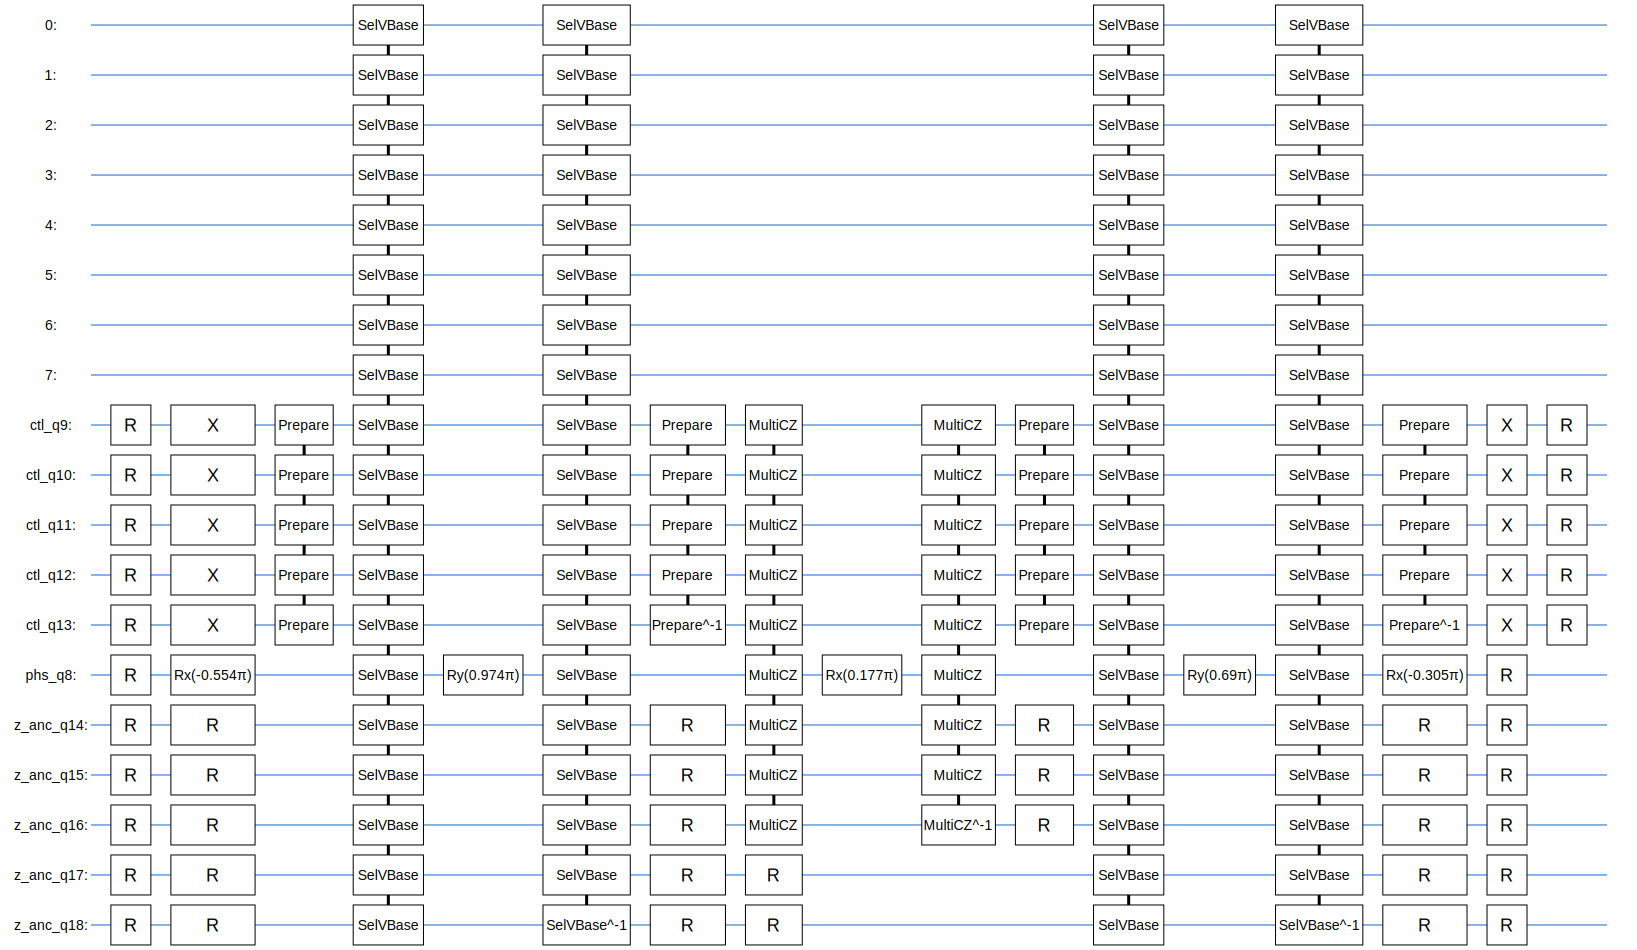

In [15]:
decomposed_circuit       = cirq.align_left(qsp_decompose_once(curr_circ))

SVGCircuit(decomposed_circuit)      # uncomment to view circuit

 As a general rule, we will see $N_\text{phi} - 1$ instances of `SelVBase` and `Prepare` (each) and $N_\text{phi} - 3$ repetitions of `MultiCZ` for a circuit containing $N_\text{phi}$ phases.  The remainder are single-qubit Pauli operations.  
 
 We will demonstrate a subcircuit analysis for  `Prepare`-`SelVBase` segment and a `MultiCZ` segment.  In the first stage, we decompose the circuit down to controlled operations (CNOT, Toffolis, etc.):

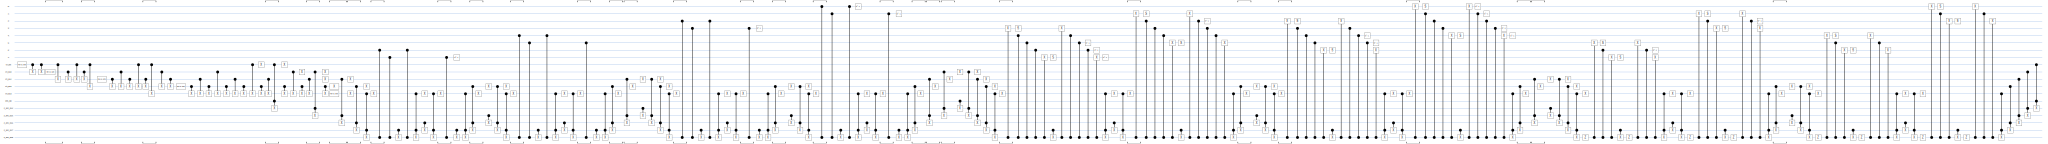

In [16]:
circ_selv_prep         =  decomposed_circuit[2:4]
circ_selv_prep_cops    =  cirq.align_left(qsp_decompose_once(circ_selv_prep))

SVGCircuit(circ_selv_prep_cops)      # uncomment to view circuit

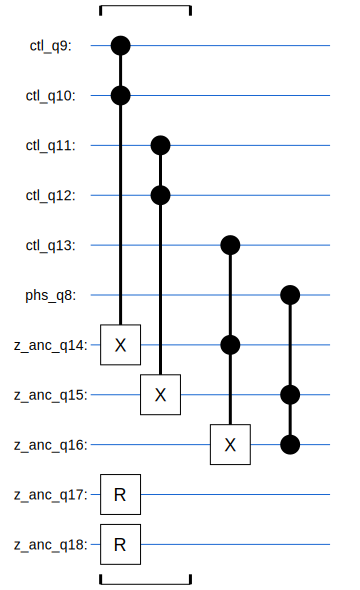

In [17]:
circ_multicz           =  decomposed_circuit[7:8]
circ_multicz_cops      =  cirq.align_left(qsp_decompose_once(circ_multicz))

SVGCircuit(circ_multicz_cops)      # uncomment to view circuit

Next,we transform into the Clifford+$T$ gate set (Note: this can take a while, even when instances are only a bit larger than our demostration scale, e.g. the $4 \times 4$ FH model):

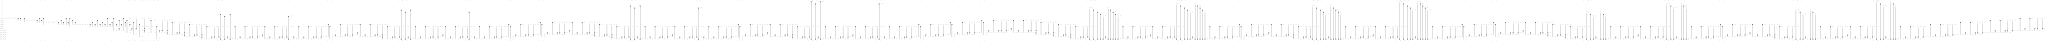

In [18]:
circ_selv_prep_cliff_t    = cirq.align_left(clifford_plus_t_direct_transform(circ_selv_prep_cops))
circ_multicz_cliff_t      = cirq.align_left(clifford_plus_t_direct_transform(circ_multicz_cops))

SVGCircuit(circ_selv_prep_cliff_t)

We can assess the $T$ count for these circuits using `get_t_counts`:

In [19]:
import resource_analysis as ran

svp_nt,svp_ntinv = ran.get_t_counts(circ_selv_prep_cliff_t)
mcz_nt,mcz_ntinv = ran.get_t_counts(circ_multicz_cliff_t)

And similarly calculate the gate depth:

In [20]:
depth_selv_prep_cops      =  ran.get_gate_depth(circ_selv_prep_cops)
depth_selv_prep_cliff_t   =  ran.get_gate_depth(circ_selv_prep_cliff_t)

depth_multicz_cops        =  ran.get_gate_depth(circ_multicz_cops)
depth_multicz_cliff_t     =  ran.get_gate_depth(circ_multicz_cliff_t)

Finally printing the statistics:

In [21]:
print()
print("Prepare + Select\n================================")
print(" Clifford+T Depth:\t", depth_selv_prep_cliff_t)
print(" T Count:\t\t", svp_nt)
print(" T^dag Count:\t\t", svp_ntinv)
print(" T Total:\t\t", svp_nt + svp_ntinv)

print("\n")
print("MultiCZ\n================================")
print(" Clifford+T Depth:\t", depth_multicz_cliff_t)
print(" T Count:\t\t", mcz_nt)
print(" T^dag Count:\t\t", mcz_ntinv)
print(" T Total:\t\t", mcz_nt + mcz_ntinv)



Prepare + Select
 Clifford+T Depth:	 785
 T Count:		 186
 T^dag Count:		 248
 T Total:		 434


MultiCZ
 Clifford+T Depth:	 30
 T Count:		 12
 T^dag Count:		 16
 T Total:		 28
